### Download Data

In [1]:
import tarfile
from urllib.request import urlretrieve
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
F_SOURCE = 'beer_reviews.tar.gz'
URL_SOURCE = 'https://s3.amazonaws.com/demo-datasets/{}'.format(F_SOURCE)

In [3]:
update_data = False
if update_data:
    urlretrieve(URL_SOURCE, F_SOURCE)
    tar = tarfile.open(F_SOURCE, "r:gz")
    tar.extractall()
    tar.close()

### Load the Data

In [4]:
df = pd.read_csv('beer_reviews/beer_reviews.csv')

In [5]:
df['review_time'] = pd.to_datetime(df['review_time'], unit='s')

### References
- https://www.beeradvocate.com/community/threads/beeradvocate-ratings-explained.184726/
- https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/

### Other Resources
- http://blog.yhat.com/posts/recommender-system-in-r.html
- https://arxiv.org/pdf/1606.04155.pdf
- http://blog.jaymargalus.com/wp-content/uploads/2016/10/Beer-Advocate-Margalus.pdf
- http://kaylinwalker.com/tidy-text-beer/

### Explore the data

In [6]:
df.dtypes

brewery_id                     int64
brewery_name                  object
review_time           datetime64[ns]
review_overall               float64
review_aroma                 float64
review_appearance            float64
review_profilename            object
beer_style                    object
review_palate                float64
review_taste                 float64
beer_name                     object
beer_abv                     float64
beer_beerid                    int64
dtype: object

In [7]:
df.select_dtypes(include='float64').describe()

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv
count,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.586614e+06,1.518829e+06
mean,3.815581e+00,3.735636e+00,3.841642e+00,3.743701e+00,3.792860e+00,7.042387e+00
std,7.206219e-01,6.976167e-01,6.160928e-01,6.822184e-01,7.319696e-01,2.322526e+00
min,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02
25%,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,3.500000e+00,5.200000e+00
50%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,6.500000e+00
75%,4.500000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.500000e+00,8.500000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.770000e+01


#### Numero de cervezas evaluadas

In [8]:
df.groupby('beer_name')['beer_beerid'].count().count()

56857

#### Primero vemos distribución de la cantidad de evaluaciones para cada cerveza:
Vemos que tienen una distribución Pareto

C:\Users\Javier\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:1743: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


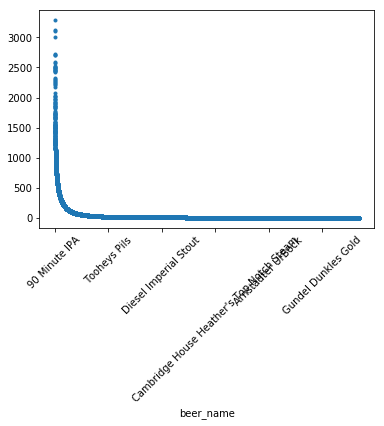

In [9]:
df.groupby('beer_name')['beer_beerid'].count().sort_values(ascending=False).plot(rot=45, style='.')

### 1. ¿Qué cervecería produce la cerveza más fuerte según ABV?

In [10]:
top_ABV = df.sort_values('beer_abv', ascending=False).head(1)
top_ABV.brewery_name.values[0]

'Schorschbräu'

### 2. Elegir 3 cervezas para recomendar

#### Tomamos las primeras 2500 cervezas con más evaluaciones
Nos quedamos con las cervezas que han sido evaluadas por al menos 134 personas

In [11]:
df.groupby('beer_name')['beer_beerid'].count().sort_values(ascending=False).head(2500).tail()

beer_name
33 Export                                134
Lips Of Faith - Sahti                    134
Smoke From The Oak (Wine Barrel Aged)    134
Kosmyk Charlie Y2K Catastrophe Ale       134
Struiselensis                            134
Name: beer_beerid, dtype: int64

In [12]:
top_2500 = df.groupby('beer_name')['beer_beerid'].count().sort_values(ascending=False).head(2500).index

In [13]:
top_eval = df[df.beer_name.isin(top_2500)].copy()

#### Calculamos el weighted_rating
https://www.beeradvocate.com/community/threads/how-to-review-a-beer.241156/

- Appearance (Look) = 6% -> review_appearance
- Smell = 24% -> review_aroma
- Taste = 40% -> review_taste
- Mouthfeel (Feel) = 10% -> review_palate
- Overall = 20% -> review_overall

In [14]:
top_eval['weighted_rating'] = top_eval.eval('review_appearance * 0.06 + review_aroma * 0.24 + \
                                              review_taste * 0.4 + review_palate * 0.1 + review_overall * 0.2')

### 2. ¿Si tuviera que elegir 3 cervezas para recomendar usando sólo estos datos, cuáles elegiría?

In [15]:
top_eval.groupby('beer_name')['weighted_rating'].mean().sort_values(ascending=False).head(3)

beer_name
Pliny The Younger              4.673738
Rare Bourbon County Stout      4.649317
Vanilla Bean Aged Dark Lord    4.646184
Name: weighted_rating, dtype: float64

### 3. ¿Cuál de los factores (aroma, taste, apperance, palette) es más importante para determinar la calidad general de una cerveza?
Segun la referencia anterior Taste = 40% -> review_taste (El sabor)

### 4. ¿Si yo típicamente disfruto una cerveza debido a su aroma y apariencia, qué estilo de cerveza debería probar?

In [16]:
top_eval['custom_rating'] = top_eval.eval('review_appearance * 0.5 + review_aroma * 0.5')
top_eval.groupby('beer_style')['custom_rating'].mean().sort_values(ascending=False).head(3)

beer_style
American Double / Imperial Stout    4.192955
Russian Imperial Stout              4.163160
Quadrupel (Quad)                    4.152978
Name: custom_rating, dtype: float64